# Introduction

This notebook demonstrates the implementation of a logistic model using tensorflow library. The MNIST dataset is used for learning the model.

## Imports 
The libraries that are required to implement the model are imported

In [1]:
import numpy as np   # scientific computing library
import tensorflow as tf  # library to implement ML
import matplotlib.pyplot as plt # to plot graphs 

In [2]:
print 'Library versions used.'
print 'Numpy :{} \nTensorflow :{}'.format(np.version.version, tf.__version__)

Library versions used.
Numpy :1.13.1 
Tensorflow :1.2.1


## Data  download
The MNIST dataset is downloaded from the tensorflow website in one_hot vector format

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST is split into three part: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

In [4]:
print 'Data Size'
print 'Training Data \t:', len(data.train.labels)
print 'validation Data :', len(data.validation.labels)
print 'Testing Data \t:', len(data.test.labels)

Data Size
Training Data 	: 55000
validation Data : 5000
Testing Data 	: 10000


## Example of training data
Each image in the MNIST dataset is a 28x28 grey-scale image which is flattened into a single a vector of 784 numbers.

In [5]:
print 'Training image vector size :', len(data.train.images[0]) #Size of a training image

Training image vector size : 784


Each image has the possibility of being any of the 10 numbers from 0-9. Thus yielding the labels of the image to be a one_hot vector denoting that particular number present in the image.

In [6]:
print 'Number of labels :', len(data.train.labels[0])
print 'Example of a label :', data.train.labels[0]

Number of labels : 10
Example of a label : [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


The labels of the input images are required in single values as well which would help us in further functions like for calculating accuracy or in plotting the true lable with image.

In [7]:
data.validation.cls = np.array([label.argmax() for label in data.validation.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions
The data dimensions will be used in different places in the code and hard-coding them in each place is not a good practice and makes debugging harder. So we define them as variables and use the variable name in othe rlocation


In [8]:
image_size = 28
image_size_flatten = image_size * image_size
num_labels = 10

We can see that in the above example the number in the image correspondes to 7 since the entry of index 6 (index starts from 0) is set to 1.

## Visualizing the data as image
Lets buid a helper function that uses the training vector to reconstruct the 28x28 image. For easier implementation we make sure that we always pass 9 images to the function.

In [9]:
def plot_image(images, labels):  # we pass the images and the corresponding labels to the function to plot
    assert len(images) == len(labels) #verify that the same length of images and labels are passed on
    
    fig, axes = plt.subplots(3, 3)  #create a subplots in 3 rows and 3 colums since we plot for 9 images
    fig.subplots_adjust(hspace=0.3, wspace=0.3) # provide spacing between the subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_size,image_size), cmap='binary') # plot the i_th image
        
        # Remove the ticks in the axes
        ax.set_xticks([])
        ax.set_yticks([])
        
        #Print the true label of the image
        xlabel = "True: {}".format(np.argmax(labels[i]))
        ax.set_xlabel(xlabel)
        
    plt.show()

## Let's plot the first 9 images in the dataset and check

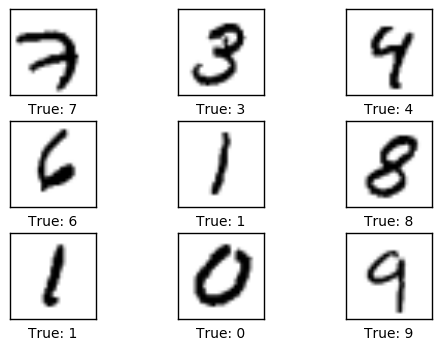

In [10]:
plot_image(data.train.images[0:9], data.train.labels[0:9])

# Tensorflow

Now we have our data, we shall build the computational graph in tensorflow for the learning model.

First thing is to define the placeholders that act as gateway to pass the input to the computational graph.

## Placeholder for the input

Defining this makes us to pass the input images to the tensorflow graph. the datatype is set to float32 and the shape is [None, image_size] which means we can pass arbitraty number of images with each image containting a vector of size image_size. 

In [11]:
x = tf.placeholder(tf.float32, [None, image_size_flatten])

We define two other place holders y and y_cls through which we can input the labels of the image. y is defined to have a datatype float32 with shape [None, num_labels] since each image labels is a one hot vector of size num_labels (i.e 10 in our case). and y_cls is defined to have a datatype int16 with shape [None] since it holds the true class of each image as number.

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_labels])
y_true_cls = tf.placeholder(tf.int64, [None])

## Variable in the model

A simple perceptron is as below :
<img src="https://qph.ec.quoracdn.net/main-qimg-a02a06108f914443fd28b925c3b998d5" alt="Drawing" style="width: 300px;"/>

The image shows the prediction of a single output as in case of regression models, but since we are performing the classification task, the number of neurons in the output layer will be equal to the number of labels(i.e 10).

So the weight matrix should be of size [image_size_flatten, num_labels] and each neuron in the output layer has a bias value which allows to shift the boundary between the classes appropriately for better classification.

In [13]:
weights = tf.get_variable('proj_w', [image_size_flatten, num_labels], tf.float32)
biases = tf.get_variable('proj_b', [num_labels], tf.float32)

## Model

The simple model of y = ax + b is performed where x is the input

In [14]:
logits = tf.matmul(x, weights) + biases

The logits is a matrix of shape [num_images x num_labels]. The models outputs a score to each possible output label, but we require the output to be a list of probability score equalling to one for a given input over all possible output labels.

The softmax function performs this operation. It takes matrix of values and for each row computes the probability of values based on the score such that the sum of all values in a row equals to one.

In [15]:
y_pred = tf.nn.softmax(logits)

The predicted label can be calculated by just looking at the idex of the value with maximum probability

In [16]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Now that we predicted some output for a given image, we need to tell the model the error it has made compared to the original label. This is done by the cross_entropy operation which calculates the error made in each image prediction.

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

To optimize the model's variables we need a single scalar value which can be done by just taking the mean of all of all values. The reduce_mean function performs this operation and outputs a single scalar value

In [18]:
error = tf.reduce_mean(cross_entropy)

## Optimizer

Now that we have the error calculated, we need to optimize the model variable's according to the error such that the objective is to minimize the error. Various optimizers have been proposed iin tensorflow but here we use "AdamOptimizer" with a learning_rate of 0.1.

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(error)

## Accuracy measure
we define the below measures so that we can measure how well our model performs. The tf.equal function compares the inputs and returns a boolean tensor saying if the values in both inputs passed are equal or not.
The reduce_mean function then calculates the mean of all values in the tensor giving us the exact fraction(0 to 1) of correct prediction. 

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training

Now that we have everything setup lets train the model.

To execute the tensorflow graph we need to create a session initially and then the variables of the model are initialied before we start to train the model

In [21]:
session = tf.Session()
session.run(tf.global_variables_initializer())

Since the input is of over 50k images, inputting them in a single go to the model will take considerable resources and also calculating the gradient of the model takes long time. So instead we pass input as batches of images.

And the more the model go over the input it can learn to better classify the image. The epoch variable denotes the number of times the complete dataset must be passed on to the model for learning. Having a higher epoch would overfit the model as well so we always need to check the accuracy on the validation dataset to check which model performs better.

In [22]:
batch_size = 64
epoch = 10

## Saving model

Let's define the path to save the best model while training.

In [23]:
# path to save the model
save_path = 'Checkpoints/model'

# create an object for the Saver function in tensorflow which we will use to save the model
saver = tf.train.Saver()

Let's train the model. The training is written as a function so we can later call this function to train the model. 

In [24]:
def train(epoch=10, batch_size=64):
    acc = get_accuracy('validation') #get initial accuracy on validation set
    for i in range(epoch):           # number of times to pass over the dataset for training
        # calculate the total number of batches in the input dataset
        total_batch = int(len(data.train.images)/batch_size) 
        # pass each batch to the model for learning
        for i in range(total_batch):
            # get the next batch of input data
            x_batch, y_batch = data.train.next_batch(batch_size)
            
            # denote the data that needs to passes onto the placeholders defined in the tensorflow graph
            feed_dict = {x: x_batch, y_true: y_batch}
            
            # run the optimizer using this batch of data
            session.run(optimizer, feed_dict)
            
            # get the current models accuracy on validation dataset
            new_acc = get_accuracy('validation')
            
            # if the validation accuracy of the current model is greater than the previous model 
            # we save this as the best model
            if new_acc >= acc :
                acc = new_acc
                saver.save(session, save_path)                

We implement a helper function that calls the above defined accuracy measure and prints the accuracy of the model

In [25]:
def get_accuracy(datatype='test'):  
    # datatype parameter denotes if the accuracy is to be 
    # calculated on test or validation data
    
    # pass the test data to the placeholders as input since we require the accuracy on test data
    if datatype == 'test':
        feed_dict_test = {x: data.test.images,
                      y_true: data.test.labels,
                      y_true_cls: data.test.cls}
    else: 
        feed_dict_test = {x: data.validation.images,
                      y_true: data.validation.labels,
                      y_true_cls: data.validation.cls}    
    # Compute the accuracy on the test data
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # convert accuracy in fraction to percentage and keep it to 1 decimal place
    acc = round(acc * 100, 1)
    
    return acc

Let's check the accuracy of the initial model without any training done.

In [26]:
print 'Accuracy of inital model :{}%'.format(get_accuracy('test'))

Accuracy of inital model :8.1%


Now let's train the model for 2 epochs and check the accuracy of it.

In [27]:
train(epoch=2)
print 'Accuracy of the trained model :{}%'.format(get_accuracy('test'))

Accuracy of the trained model :89.3%


## Restore the best model that was saved while training

In [28]:
saver.restore(session, save_path)
print 'Accuracy of the best model :{}%'.format(get_accuracy('test'))

INFO:tensorflow:Restoring parameters from Checkpoints/model
Accuracy of the best model :90.2%


Now that we have a trained model let's try to visualize the weights that the model has learnt to predict the output label.

We implement a function that plots the weights of the model. 10 different images each denoting the weights learnt for a particual digit (0-9) is plotted.

In [29]:
def plot_weights():
    # get the weights of the model
    w = session.run(weights)
    
    # since we plot the image as color density, we need to know the minimum and maximum.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # create a plot with 10 subplots one for each digit
    fig, axes = plt.subplots(2,5)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        img = w[:, i].reshape(image_size, image_size)
        ax.imshow(img, vmin=w_min, vmax=w_max, cmap='seismic')
        
        # Remove the ticks in the axes
        ax.set_xticks([])
        ax.set_yticks([])
        
        #Print the true label of the image
        xlabel = "Weights: {}".format(i)
        ax.set_xlabel(xlabel)
        
    plt.show()

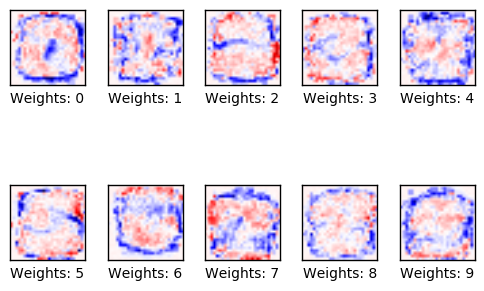

In [30]:
plot_weights()

## Close the tensorlfow session

In [31]:
session.close()